<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/xgboast_3_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load datasets
train = pd.read_csv('/content/drive/MyDrive/Dataset_for_Train_Validation_Test/train.csv')
val = pd.read_csv('/content/drive/MyDrive/Dataset_for_Train_Validation_Test/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset_for_Train_Validation_Test/test.csv')


In [6]:
# Bin 'Production (M.Ton)' into 3 quantile-based classes
combined = pd.concat([train, val])
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
binner.fit(combined[['Production (M.Ton)']])

train['Production_Class'] = binner.transform(train[['Production (M.Ton)']]).astype(int)
val['Production_Class'] = binner.transform(val[['Production (M.Ton)']]).astype(int)
test_y_binned = binner.transform(test[['Production (M.Ton)']]).astype(int) if 'Production (M.Ton)' in test else None

In [7]:
# Prepare features and labels
X_train = train.drop(columns=['Production (M.Ton)', 'Production_Class'])
y_train = train['Production_Class']
X_val = val.drop(columns=['Production (M.Ton)', 'Production_Class'])
y_val = val['Production_Class']
X_test = test.drop(columns=['Production (M.Ton)'], errors='ignore')

In [8]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Train XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:0.99828	validation_1-mlogloss:1.00299
[1]	validation_0-mlogloss:0.91395	validation_1-mlogloss:0.92289
[2]	validation_0-mlogloss:0.84079	validation_1-mlogloss:0.85529
[3]	validation_0-mlogloss:0.77740	validation_1-mlogloss:0.79706
[4]	validation_0-mlogloss:0.72266	validation_1-mlogloss:0.74702
[5]	validation_0-mlogloss:0.67362	validation_1-mlogloss:0.70283
[6]	validation_0-mlogloss:0.63020	validation_1-mlogloss:0.66406
[7]	validation_0-mlogloss:0.59151	validation_1-mlogloss:0.62872
[8]	validation_0-mlogloss:0.55753	validation_1-mlogloss:0.59885
[9]	validation_0-mlogloss:0.52649	validation_1-mlogloss:0.57117
[10]	validation_0-mlogloss:0.49820	validation_1-mlogloss:0.54666
[11]	validation_0-mlogloss:0.47354	validation_1-mlogloss:0.52531
[12]	validation_0-mlogloss:0.45040	validation_1-mlogloss:0.50499
[13]	validation_0-mlogloss:0.43062	validation_1-mlogloss:0.48706


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:58:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-mlogloss:0.41237	validation_1-mlogloss:0.47158
[15]	validation_0-mlogloss:0.39580	validation_1-mlogloss:0.45726
[16]	validation_0-mlogloss:0.38058	validation_1-mlogloss:0.44350
[17]	validation_0-mlogloss:0.36573	validation_1-mlogloss:0.43075
[18]	validation_0-mlogloss:0.35316	validation_1-mlogloss:0.42041
[19]	validation_0-mlogloss:0.34146	validation_1-mlogloss:0.41015
[20]	validation_0-mlogloss:0.33091	validation_1-mlogloss:0.40090
[21]	validation_0-mlogloss:0.32023	validation_1-mlogloss:0.39149
[22]	validation_0-mlogloss:0.31059	validation_1-mlogloss:0.38348
[23]	validation_0-mlogloss:0.30220	validation_1-mlogloss:0.37674
[24]	validation_0-mlogloss:0.29444	validation_1-mlogloss:0.36960
[25]	validation_0-mlogloss:0.28724	validation_1-mlogloss:0.36363
[26]	validation_0-mlogloss:0.28096	validation_1-mlogloss:0.35807
[27]	validation_0-mlogloss:0.27492	validation_1-mlogloss:0.35245
[28]	validation_0-mlogloss:0.26885	validation_1-mlogloss:0.34777
[29]	validation_0-mloglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [10]:
# Evaluation function
def evaluate(name, y_true, y_pred):
    print(f"\n📊 {name} Classification Report")
    print(classification_report(y_true, y_pred, target_names=['Low', 'Medium', 'High']))
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1 Score: {f1_macro:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()



📊 Validation Classification Report
              precision    recall  f1-score   support

         Low       0.96      0.92      0.94       253
      Medium       0.85      0.85      0.85       258
        High       0.89      0.92      0.90       257

    accuracy                           0.90       768
   macro avg       0.90      0.90      0.90       768
weighted avg       0.90      0.90      0.90       768

Macro F1 Score: 0.8977


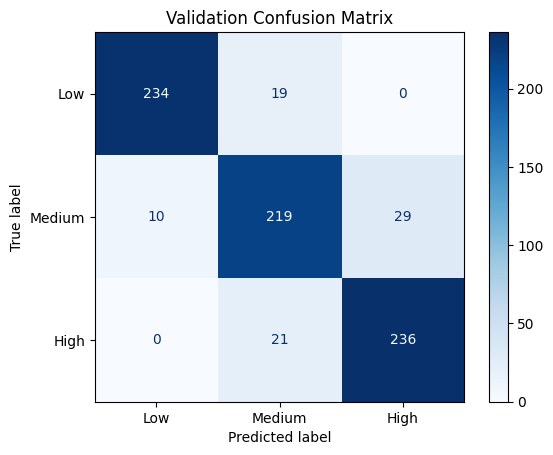

In [11]:
# Evaluate on validation
val_preds = model.predict(X_val_scaled)
evaluate("Validation", y_val, val_preds)


📊 Test Classification Report
              precision    recall  f1-score   support

         Low       0.95      0.95      0.95       256
      Medium       0.89      0.88      0.88       263
        High       0.93      0.93      0.93       249

    accuracy                           0.92       768
   macro avg       0.92      0.92      0.92       768
weighted avg       0.92      0.92      0.92       768

Macro F1 Score: 0.9209


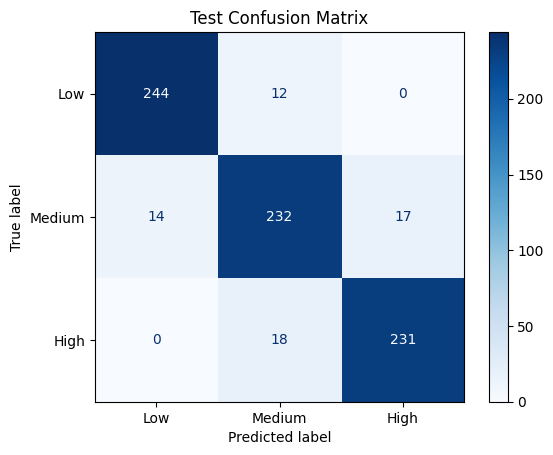

In [12]:
# Evaluate on test (if labels available)
if test_y_binned is not None:
    test_preds = model.predict(X_test_scaled)
    evaluate("Test", test_y_binned.ravel(), test_preds)


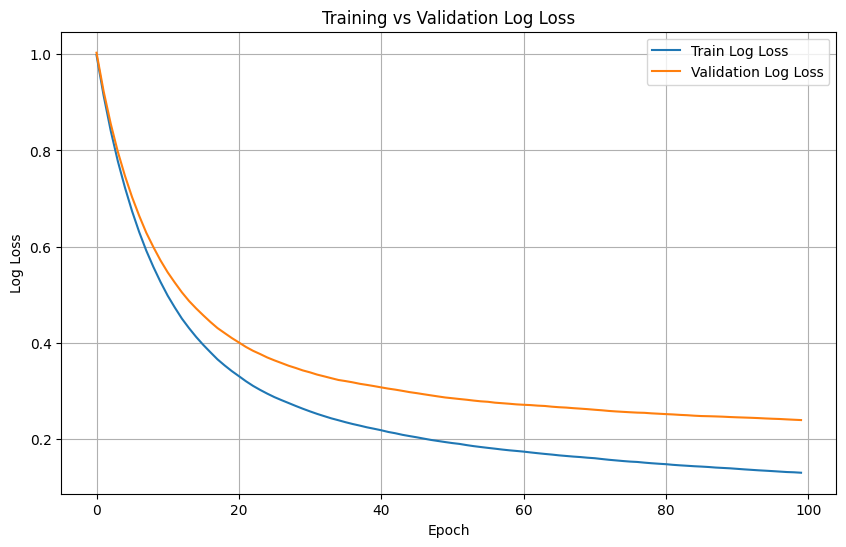

In [13]:
# Plot training vs validation log loss
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results['validation_0']['mlogloss'], label='Train Log Loss')
plt.plot(range(epochs), results['validation_1']['mlogloss'], label='Validation Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.grid(True)
plt.show()
